In [21]:
import cv2, random, os, glob, math, pathlib, csv, PIL
import zipfile

import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from os import listdir
from PIL import Image
from tqdm import tqdm 

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.models as models

from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder

## Library Set up and Unzip

In [28]:
import zipfile

with zipfile.ZipFile("/home/Sean/iRail_Self_Study/CHS/segmentation/fish.zip") as a:
    for file in tqdm(iterable = a.namelist(), total = len(a.namelist())):
        a.extract(member = file)

100%|██████████| 18436/18436 [00:22<00:00, 822.32it/s] 


## Brief EDA

In [91]:
basepath = %pwd
train_path = basepath +'/Fish_Dataset/Fish_Dataset/'

print(os.listdir(train_path))

['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'README.txt', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Segmentation_example_script.m', 'Shrimp', 'Striped Red Mullet', 'Trout', 'license.txt']


In [128]:
classes = os.listdir(train_path)
classes.sort()

del classes[3], classes[6], classes[9]
print( f'The number of classes : {len(classes)}', '\n', classes)

The number of classes : 9 
 ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


In [135]:
train_img  =  glob.glob(train_path+os.sep+"/*/*/*.png")
mask_dir  =  glob.glob(train_path+os.sep+"/*/*GT/*.png")
image_dir = list(set(train_img) - set(train_img_mask))

print(f"The total number of the Data: {len(train_img)}")
print(f"The number of the raw Data: {len(image_dir)} \nThe number of the mask Data: {len(mask_dir)}")

The total number of the Data: 18000
The number of the raw Data: 9000 
The number of the mask Data: 9000


Type of the random image: <class 'numpy.ndarray'> 
Shape of the random image: '(445, 590, 3), 
Path : /home/Sean/iRail_Self_Study/CHS/segmentation/Fish_Dataset/Fish_Dataset/Striped Red Mullet/Striped Red Mullet/00535.png


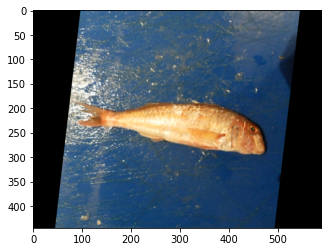

In [105]:
rand_path = random.choice(train_img)
rand_img = mpimg.imread(rand_path)
plt.imshow(rand_img)

print( f"Type of the random image: {type(rand_img)} \nShape of the random image: '{rand_img.shape}, \nPath : {rand_path}")

In [152]:
from sklearn.model_selection import train_test_split

x_train, x_val ,y_train, y_val = train_test_split(
    image_dir,
    mask_dir,
    test_size=0.2, 
    random_state=42, 
    shuffle=True)

## STD and Mean (X)

## U-Net : Modeling

In [157]:
import torch 
import torch.nn as nn 
import torchvision.transforms.functional as TF

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"'{DEVICE}' is avilable.")

'cuda' is avilable.


In [190]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [191]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

## U-Net : Dataset

In [192]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [193]:
class FishDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype = np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image = image, mask = mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        
        return image, mask

## U-Net : utils

In [194]:
import torch
import torchvision
from torch.utils.data import DataLoader

In [195]:
def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = LargeScaleFishDataset(
        inputs=train_dir,
        targets=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = LargeScaleFishDataset(
        inputs=val_dir,
        targets=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

In [196]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    

In [197]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(
    loader, model, folder="saved_images/", device="cuda"
):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()    
    
os.makedirs("saved_images", exist_ok=True)

## U-Net : Train

In [198]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms.functional as TF
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

import numpy as np
import os
from pathlib import Path
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## U-Net : Hyperparameters

In [199]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 160  # 1280 originally
IMAGE_WIDTH = 240  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = False

In [200]:

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        x_train,
        y_train,
        x_val,
        y_val,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )

In [201]:
if __name__ == "__main__":
    main()

  0%|          | 0/225 [00:00<?, ?it/s]

Got 57639844/69120000 with acc 83.39
Dice score: 0.0


100%|██████████| 225/225 [01:16<00:00,  2.96it/s, loss=0.383]


=> Saving checkpoint
Got 59847957/69120000 with acc 86.59
Dice score: 0.5339058637619019


100%|██████████| 225/225 [00:59<00:00,  3.80it/s, loss=0.342]


=> Saving checkpoint
Got 60028061/69120000 with acc 86.85
Dice score: 0.5074554681777954


100%|██████████| 225/225 [00:59<00:00,  3.78it/s, loss=0.34] 


=> Saving checkpoint
Got 60030910/69120000 with acc 86.85
Dice score: 0.5083107352256775
